# Intro Example

In [118]:
import cvxpy as cp
import math
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters, plot_contours, plot_contours_line
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":24,
    "font.family": "serif"
})

In [119]:
# Formulate constants
n = 2
N = 500
test_perc = 0.99
k_init = np.array([4.,5.])
p = np.array([5,6.5])


def gen_demand_intro(N, seed):
    np.random.seed(seed)
    sig = np.array([[0.6,-0.3],[-0.3,0.1]])
    mu = np.array((1.1,2.7))
    norms = np.random.multivariate_normal(mu,sig, N)
    # d_train = np.exp(norms)
    return norms

def gen_demand_cor(N,seed,x):
    np.random.seed(seed)
    sig = np.eye(2)
    mu = np.array((6,7))
    points_list = []
    for i in range(N):
        mu_shift = -0.4*x[i]
        newpoint = np.random.multivariate_normal(mu+mu_shift,sig)
        points_list.append(newpoint)
    return np.vstack(points_list)
        
# Generate data
data = gen_demand_intro(N, seed=5)

In [120]:
test_p = 0.9
s = 8
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(np.cov(train.T))
init_bval = np.mean(train, axis=0)

In [138]:
# solve for mean-variance opt solution 
z = cp.Variable(2)
c = cp.Parameter(2)
b = cp.Parameter(2)
A = cp.Parameter((2,2))
ub = 1

objective = cp.Minimize(c@z)
constraints = [b@z + cp.norm(A.T@z,2) <=ub]
constraints += [cp.norm(z)<=1]
problem = cp.Problem(objective,constraints)

b.value = init_bval
A.value = init
c.value = np.array([-1, -1])
problem.solve()
objval_mv = problem.objective.value
zval_mv = z.value
# solve for mean-var worst u
v = cp.Variable(2)
cp.Problem(cp.Minimize(-v@(A.T@z).value),[v@(A.T@z).value <= ub-b.value@zval_mv, cp.norm(v,2)<=1]).solve()
vval_mv = v.value
uval = init@vval_mv + init_bval

# solve for reshaped opt solution
newb= np.array([1.25,2.5])
# newA = 1.5*np.eye(2)
newA = 0.5*np.array([[0.6,-0.2],[-0.2,0.6]])
# newA = np.random.rand(2,2)
colors = ['orange','red','purple','green','brown']
inds = [0.5,1,2,3,4]
zval_new = []
objval_new = []
vval_new = []
uval_new = []
for j in range(len(inds)):
    b.value = newb
    A.value = inds[j]*newA
    problem.solve()
    zval_new.append(z.value)
    objval_new.append(problem.objective.value)
    # solve for reshaped worst u
    v = cp.Variable(2)
    cp.Problem(cp.Minimize(-v@(A.T@z).value),[v@(A.T@z).value <= ub-b.value@z.value, cp.norm(v,2)<=1]).solve()
    vval_new.append(v.value)
    uval_new.append(A.value@v.value + b.value)

In [139]:
K = 1
eps_list = [1]
Amat = [newA]
bvec = [newb]
num_p = 50
offsetx = 2
x_min, x_max = np.min(train[:,0]) - offsetx, np.max(train[:,0]) + offsetx
y_min, y_max = np.min(train[:,1]) - offsetx, np.max(train[:,1]) + offsetx
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
Z = zval_mv[0]*x + zval_mv[1]*y - ub
Z_new = {}
for j in range(len(inds)):
    Z_new[j] = zval_new[j][0]*x + zval_new[j][1]*y - ub
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(len(inds)):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(len(inds)):
    g_level_learned[ind] = {}
    g_level_base[ind] = {}
    for scene in range(10):
        g_level_learned[ind][scene] = np.zeros((num_p,num_p))
        g_level_base[ind][scene] = np.zeros((num_p,num_p))
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/inds[ind])*(Amat[k_ind].T@np.linalg.inv(Amat[k_ind]@Amat[k_ind].T))@(u_vec - bvec[k_ind]))
            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[0])*(init.T@np.linalg.inv(init@init.T))@(u_vec  - init_bval))

In [140]:
sols = []
objs = []
for i in train:
  nz = cp.Variable(2)
  nobjective = cp.Minimize(c@nz)
  nconstraints = [i@nz <= ub]
  nconstraints += [cp.norm(nz) <= 1]
  nproblem = cp.Problem(nobjective,nconstraints)
  nproblem.solve()
  sols.append(nz.value)
  objs.append(nproblem.objective.value)
  # print(nproblem.objective.value)

# uval = init@vval_mv + init_bval
# nzmv = cp.Variable(2)
# nobjective = cp.Minimize(c@nzmv)
# nconstraints = [uval@nzmv <= ub]
# nconstraints += [cp.norm(nzmv) <= 1]
# nproblem = cp.Problem(nobjective,nconstraints)
# nproblem.solve()
# uobj = nproblem.objective.value

# uval_new = newA@vval_new[0] + newb
# nz = cp.Variable(2)
# nobjective = cp.Minimize(c@nz)
# nconstraints = [uval_new@nz <= ub]
# nconstraints += [cp.norm(nz) <= 1]
# nproblem = cp.Problem(nobjective,nconstraints)
# nproblem.solve()
# uobj_new = nproblem.objective.value

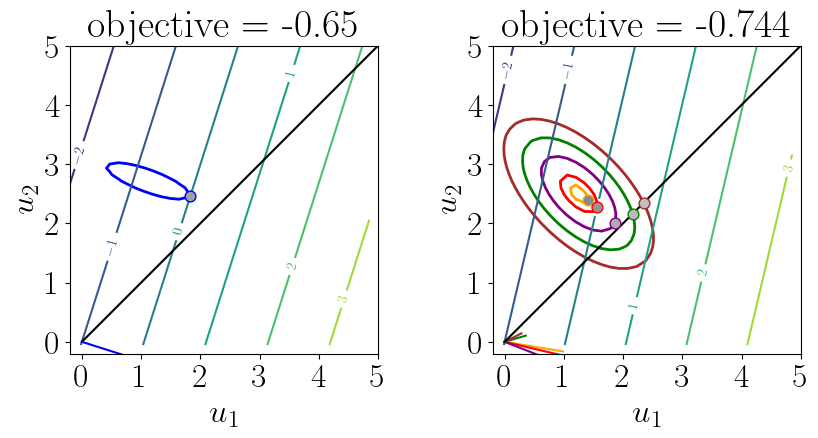

In [143]:
offset = 0.5
fig, (ax,ax2) = plt.subplots(1,2, figsize = (10,4))
ax.set_xlabel(r"$u_1$")
ax.set_ylabel(r"$u_2$")
ax.set_title(r'objective' + ' = {}'.format(round(objval_mv,3)))
# tpoints = ax.scatter(train[:,0],train[:,1], c = objs, cmap='gray',edgecolor = "black", vmin = np.min(objs)-offset, vmax = np.max(objs)+offset)
# fig.colorbar(tpoints, ax=ax)
for k_ind in range(K):
    ax.contour(x,y,init_set[0][k_ind], [1], colors = ["blue"],linewidths = [2])
Zcont = ax.contour(x,y,Z,np.arange(-3,5,1))
ax.clabel(Zcont, inline=1, fontsize=10)
ax.plot(np.arange(10), np.arange(10), color = "black")
ax.plot([0,zval_mv[0]], [0,zval_mv[1]], color = "blue")
ax.scatter(uval[0],uval[1], c=objval_mv,cmap='gray',edgecolor = "blue", vmin = np.min(objs)-offset, vmax = np.max(objs)+offset,zorder = 10,s = 60)

# fig, ax = plt.subplots(figsize = (5,3))
ax2.set_xlabel(r"$u_1$")
ax2.set_ylabel(r"$u_2$")
ax2.set_title(r'objective' + ' = {}'.format(round(objval_new[1],3)))
# tpoints = ax2.scatter(train[:,0],train[:,1], c = objs, cmap='gray',edgecolor = "black", vmin = np.min(objs)-offset, vmax = np.max(objs)+offset)
# fig.colorbar(tpoints, ax=ax2)
for k_ind in range(K):
    for j in range(len(inds)):
        # ax.contour(x,y,init_set[0][k_ind], [1], colors = ["red"],linewidths = [2])
        ax2.contour(x,y,fin_set[j][k_ind], [1], colors = colors[j],linewidths = [2])
Zcont = ax2.contour(x,y,Z_new[1],np.arange(-3,5,1))
ax2.clabel(Zcont, inline=1, fontsize=10)
for j in range(len(inds)):
    ax2.scatter(uval_new[j][0],uval_new[j][1], c=objval_new[j],cmap='gray',edgecolor = colors[j], vmin = np.min(objs)-offset, vmax = np.max(objs)+offset,zorder = 10,s=60)
    ax2.plot([0,zval_new[j][0]], [0,zval_new[j][1]], color = colors[j])

ax2.plot(np.arange(10), np.arange(10), color = "black")
ax2.set_xlim([-0.2,5])
ax2.set_ylim([-0.2,5])
ax.set_xlim([-0.2,5])
ax.set_ylim([-0.2,5])
ax.set_xticks(np.arange(6))
ax.set_yticks(np.arange(6))
ax2.set_xticks(np.arange(6))
ax2.set_yticks(np.arange(6))
ax.set_aspect("equal",adjustable="box")
ax2.set_aspect("equal",adjustable="box")
plt.show()


In [146]:
def calc_angle(a, b):
  return math.degrees(math.acos((a@b/(np.linalg.norm(a)*np.linalg.norm(b)))))
print("zval_mv and norm of z and u: ", zval_mv, np.linalg.norm(zval_new),  np.linalg.norm(init@vval_mv + init_bval))
print("zval_new and norm of z and u: ")
for j in range(len(inds)):
    print(zval_new[j], np.linalg.norm(zval_new[j]), np.linalg.norm(inds[j]*newA@vval_new[j] + newb))
print("we want to maximize: ")
print("angle between u_mv and x_mv: ", calc_angle(zval_mv,init@vval_mv + init_bval))
print("angle between u_new and x_new: ")
for j in range(len(inds)):
    print(calc_angle(zval_new[j],inds[j]*newA@vval_new[j] + newb))
print("we want to minimize: ")
print("angle between -c and x_mv: ",   calc_angle(zval_mv,-c.value))
print("angle between -c and x_new: ")
for j in range(len(inds)):
    print(calc_angle(zval_new[j],-c.value))

zval_mv and norm of z and u:  [ 0.95303028 -0.30287502] 1.799847220650457 3.0649378354767034
zval_new and norm of z and u: 
[ 0.9867216  -0.16242068] 0.9999999996029983 2.774044937527912
[ 0.97339946 -0.22911456] 0.9999999963745311 2.7568248124863213
[ 0.93076855 -0.3656089 ] 0.9999999773131668 2.7387495883134845
[0.35716616 0.10537794] 0.37238713320936795 3.057529577677548
[0.28369006 0.14247051] 0.3174553419331463 3.3184928018403923
we want to maximize: 
angle between u_mv and x_mv:  70.95741069560239
angle between u_new and x_new: 
68.8700506745103
68.73167259833521
68.58440801196126
28.564022714920398
18.33363573595262
we want to minimize: 
angle between -c and x_mv:  62.63036557006215
angle between -c and x_new: 
54.34742930081875
58.24494789654592
66.44506085700161
28.561886304845707
18.333977569011097


Fixing the solution $z^{\star}$ at the worst-case point (red), we depict contour lines for the constraint values $g(z^{\star},u) = z^{\star T}u$.

Individually considering each point as the worst-case $u$ (disregarding all other points), we show using a grayscale colormap the optimal objective value achieved. The solutions $z^{\star}$ is different for each point.

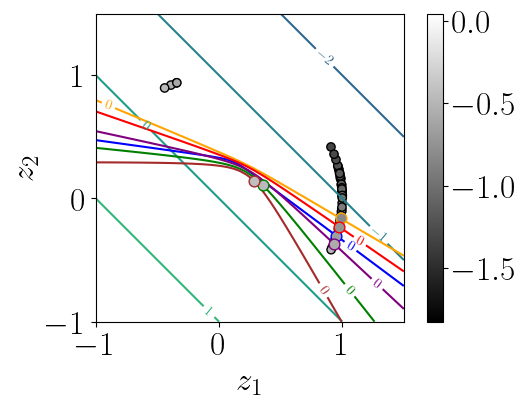

In [152]:
def get_region(A,b,x=x,y=y,num_p=num_p):
    Z_unc = np.zeros((num_p,num_p))
    for i in range(num_p):
        for j in range(num_p):
            Z_unc[i,j] = b[0]*x[i,j] + b[1]*y[i,j] + np.linalg.norm(A.T@np.array([x[i,j],y[i,j]])) - ub
    return Z_unc
num_p = 50
x_min, x_max = -1,1.5
y_min, y_max = -1,1.5
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
Z_obj = c.value[0]*x + c.value[1]*y
Z_unc = get_region(init,init_bval,x,y,num_p)

fig, (ax) = plt.subplots(1,1, figsize = (6,4))
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
# ax.set_title(r'objective' + ' = {}'.format(round(uobj,3)))
tpoints = ax.scatter(np.vstack(sols)[:,0],np.vstack(sols)[:,1], c = objs, cmap='gray',edgecolor = "black", vmin = np.min(objs)-offset, vmax = np.max(objs)+offset)
fig.colorbar(tpoints, ax=ax)
ax.scatter(zval_mv[0],zval_mv[1], c=objval_mv,cmap='gray',edgecolor = "blue", vmin = np.min(objs)-offset, vmax = np.max(objs)+offset,zorder = 10,s = 60)
Zcont = ax.contour(x,y,Z_obj,np.arange(-5,5,1))
ax.clabel(Zcont, inline=1, fontsize=10)
Z_feasible = ax.contour(x,y,Z_unc,0, colors='blue')
ax.clabel(Z_feasible, inline=1, fontsize=10)
for j in range(len(inds)):
    Z_unc_new = get_region(inds[j]*newA,newb,x,y,num_p)
    Z_feasible_new = ax.contour(x,y,Z_unc_new,0, colors=colors[j])
    ax.clabel(Z_feasible_new, inline=1, fontsize=10)
    ax.scatter(zval_new[j][0],zval_new[j][1], c=objval_new[j],cmap='gray',edgecolor = colors[j], vmin = np.min(objs)-offset, vmax = np.max(objs)+offset,zorder = 10,s = 60)
ax.set_aspect("equal",adjustable="box")
plt.show()


### Piecewise

In [113]:
z = cp.Variable(2)
c = cp.Parameter(2)
b = cp.Parameter(2)
A = cp.Parameter((2,2))
c2 = np.array([1.4,3.5])

objective = cp.Minimize(c@z)
constraints = [b@z + cp.norm(A.T@z,2) <= 5]
constraints += [c2@z + -b@z + cp.norm(-A.T@z,2) <=-2.5]
constraints += [z >=0]
problem = cp.Problem(objective,constraints)

b.value = init_bval
A.value = init
c.value = np.array([-1,-1])
problem.solve()
objval_mv = problem.objective.value
zval_mv = z.value
v = cp.Variable(2)
# cp.Problem(cp.Minimize(0),[v@(A.T@z).value == 5-b.value@z.value, cp.norm(v,2)<=1]).solve()
# vval_mv = v.value

newb= np.array([4,16])
# newA = 1.5*np.eye(2)
newA = 1.2*np.array([[1.6,0.3],[-.3,1.6]])
#newA = np.random.rand(2,2)
b.value = newb
A.value = newA
problem.solve()
zval_new = z.value
objval_new = problem.objective.value

In [114]:
K = 1
eps_list = [1]
Amat = [newA]
bvec = [newb]
num_p = 50
offset = 5
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
Z = np.maximum(zval_mv[0]*x + zval_mv[1]*y-5, c2@zval_mv - zval_mv[0]*x - zval_mv[1]*y +2.5)
Z_new = np.maximum(zval_new[0]*x + zval_new[1]*y -5, c2@zval_new - zval_new[0]*x - zval_new[1]*y +2.5)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(1):
    g_level_learned[ind] = {}
    g_level_base[ind] = {}
    for scene in range(10):
        g_level_learned[ind][scene] = np.zeros((num_p,num_p))
        g_level_base[ind][scene] = np.zeros((num_p,num_p))
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[0])*(Amat[k_ind].T@np.linalg.inv(Amat[k_ind]@Amat[k_ind].T))@(u_vec - bvec[k_ind]))
            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[0])*(init.T@np.linalg.inv(init@init.T))@(u_vec  - init_bval))

TypeError: 'NoneType' object is not subscriptable

In [196]:
sols = []
objs = []
for i in train:
  nz = cp.Variable(2)
  nobjective = cp.Minimize(c@nz)
  nconstraints = [i@nz <= 5]
  nconstraints += [c2@nz - i@nz <= -2.5]
  nconstraints += [nz >=0]
  nproblem = cp.Problem(nobjective,nconstraints)
  nproblem.solve()
  sols.append(nz.value)
  objs.append(nproblem.objective.value)

uval = init@vval_mv + init_bval
nzmv = cp.Variable(2)
nobjective = cp.Minimize(c@nzmv)
nconstraints = [uval@nzmv <= 5]
nconstraints += [c2@nzmv - uval@nzmv <= -2.5]
nconstraints += [nzmv >=0]
nproblem = cp.Problem(nobjective,nconstraints)
nproblem.solve()
uobj = nproblem.objective.value

uval_new = newA@vval_new + newb
nz = cp.Variable(2)
nobjective = cp.Minimize(c@nz)
nconstraints = [uval_new@nz <= 5]
nconstraints += [c2@nz - uval_new@nz <= -2.5]
nconstraints += [nz >=0]
nproblem = cp.Problem(nobjective,nconstraints)
nproblem.solve()
uobj_new = nproblem.objective.value

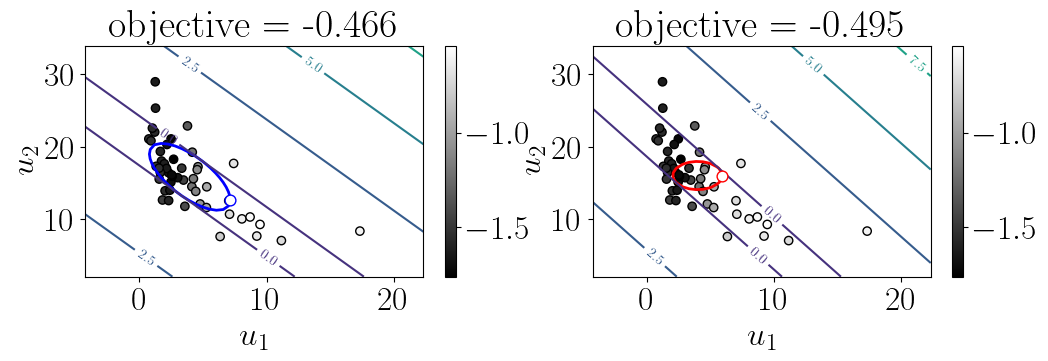

In [ ]:
fig, (ax,ax2) = plt.subplots(1,2, figsize = (12,3))
ax.set_xlabel(r"$u_1$")
ax.set_ylabel(r"$u_2$")
ax.set_title(r'objective' + ' = {}'.format(round(objval_mv,3)))
tpoints = ax.scatter(train[:,0],train[:,1], c = objs, cmap='gray',edgecolor = "black", vmin = np.min(objs), vmax = np.max(objs))
fig.colorbar(tpoints, ax=ax)
for k_ind in range(K):
    ax.contour(x,y,init_set[0][k_ind], [1], colors = ["blue"],linewidths = [2])
Zcont = ax.contour(x,y,Z,np.arange(-2.5,17,2.5))
ax.clabel(Zcont, inline=1, fontsize=10)
ax.scatter(uval[0],uval[1], c=objval_mv,cmap='gray',edgecolor = "blue", vmin = np.min(objs), vmax = np.max(objs),zorder = 10,s = 60)

# fig, ax = plt.subplots(figsize = (5,3))
ax2.set_xlabel(r"$u_1$")
ax2.set_ylabel(r"$u_2$")
ax2.set_title(r'objective' + ' = {}'.format(round(objval_new,3)))
tpoints = ax2.scatter(train[:,0],train[:,1], c = objs, cmap='gray',edgecolor = "black", vmin = np.min(objs), vmax = np.max(objs))
fig.colorbar(tpoints, ax=ax2)
for k_ind in range(K):
    # ax.contour(x,y,init_set[0][k_ind], [1], colors = ["red"],linewidths = [2])
    ax2.contour(x,y,fin_set[0][k_ind], [1], colors = ["red"],linewidths = [2])
Zcont = ax2.contour(x,y,Z_new,np.arange(-2.5,17,2.5))
ax2.clabel(Zcont, inline=1, fontsize=10)
ax2.scatter(uval_new[0],uval_new[1], c=objval_new,cmap='gray',edgecolor = "red", vmin = np.min(objs), vmax = np.max(objs),zorder = 10,s=60)
plt.show()


In [198]:
offset = 5
num_p = 50
x_min, x_max = -0.1,3
y_min, y_max = -0.1,1
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
Z_obj = c.value[0]*x + c.value[1]*y

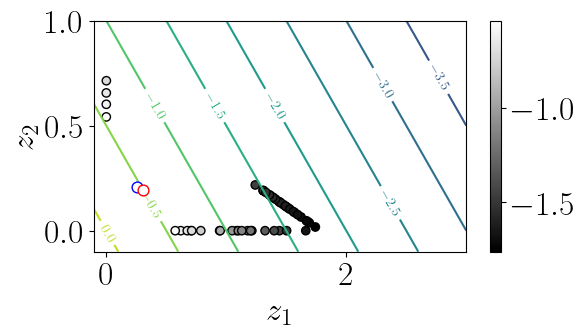

In [ ]:
fig, (ax) = plt.subplots(1,1, figsize = (6,3))
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
# ax.set_title(r'objective' + ' = {}'.format(round(uobj,3)))
tpoints = ax.scatter(np.vstack(sols)[:,0],np.vstack(sols)[:,1], c = objs, cmap='gray',edgecolor = "black", vmin = np.min(objs), vmax = np.max(objs))
fig.colorbar(tpoints, ax=ax)
ax.scatter(zval_mv[0],zval_mv[1], c=objval_mv,cmap='gray',edgecolor = "blue", vmin = np.min(objs), vmax = np.max(objs),zorder = 10,s = 60)
ax.scatter(zval_new[0],zval_new[1], c=objval_new,cmap='gray',edgecolor = "red", vmin = np.min(objs), vmax = np.max(objs),zorder = 10,s = 60)
Zcont = ax.contour(x,y,Z_obj,np.arange(-5,1,0.5))
ax.clabel(Zcont, inline=1, fontsize=10)
plt.show()
